<a href="https://colab.research.google.com/github/Drtey/chest-CT-Scan/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('key')
os.environ["KAGGLE_USERNAME"] = userdata.get('username')

In [2]:
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images
! unzip "chest-ctscan-images.zip"

100% 119M/119M [00:06<00:00, 24.5MB/s]
100% 119M/119M [00:06<00:00, 19.8MB/s]
Archive:  chest-ctscan-images.zip
  inflating: Data/test/adenocarcinoma/000108 (3).png  
  inflating: Data/test/adenocarcinoma/000109 (2).png  
  inflating: Data/test/adenocarcinoma/000109 (4).png  
  inflating: Data/test/adenocarcinoma/000109 (5).png  
  inflating: Data/test/adenocarcinoma/000112 (2).png  
  inflating: Data/test/adenocarcinoma/000113 (7).png  
  inflating: Data/test/adenocarcinoma/000114 (5).png  
  inflating: Data/test/adenocarcinoma/000114.png  
  inflating: Data/test/adenocarcinoma/000115 (4).png  
  inflating: Data/test/adenocarcinoma/000115 (8).png  
  inflating: Data/test/adenocarcinoma/000115.png  
  inflating: Data/test/adenocarcinoma/000116 (5).png  
  inflating: Data/test/adenocarcinoma/000116 (7).png  
  inflating: Data/test/adenocarcinoma/000116 (9).png  
  inflating: Data/test/adenocarcinoma/000117 (4).png  
  inflating: Data/test/adenocarcinoma/000117 (8).png  
  inflating: Dat

In [3]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.4 MB/s eta 0:00:00
time: 254 µs (started: 2024-04-16 11:00:13 +00:00)


In [4]:
%ls
%cd content/
!mv 'Data' 'data'
%ls

chest-ctscan-images.zip  Data/  sample_data/
[Errno 2] No such file or directory: 'content/'
/content
chest-ctscan-images.zip  data/  sample_data/
time: 314 ms (started: 2024-04-16 11:00:13 +00:00)


In [5]:
%ls
%cd data/train/
!mv 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib' 'adenocarcinoma'
!mv 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa' 'large.cell.carcinoma'
!mv 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa' 'squamous.cell.carcinoma'
%ls

chest-ctscan-images.zip  data/  sample_data/
/content/data/train
adenocarcinoma/  large.cell.carcinoma/  normal/  squamous.cell.carcinoma/
time: 520 ms (started: 2024-04-16 11:00:13 +00:00)


In [6]:
%ls
%cd ..
%cd valid/
!mv 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib' 'adenocarcinoma'
!mv 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa' 'large.cell.carcinoma'
!mv 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa' 'squamous.cell.carcinoma'
%ls

adenocarcinoma/  large.cell.carcinoma/  normal/  squamous.cell.carcinoma/
/content/data
/content/data/valid
adenocarcinoma/  large.cell.carcinoma/  normal/  squamous.cell.carcinoma/
time: 528 ms (started: 2024-04-16 11:00:13 +00:00)


In [7]:
import cv2
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, SubsetRandomSampler
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random
from sklearn.metrics import accuracy_score, confusion_matrix
import glob
import seaborn as sns
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from collections import Counter

time: 9.88 s (started: 2024-04-16 11:00:14 +00:00)


In [16]:
class LungCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images (train/test/valid).
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),  # Data augmentation
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
        ])

        self.labels = {"adenocarcinoma": 0, "large.cell.carcinoma": 1, "normal": 2, "squamous.cell.carcinoma": 3}
        self.filepaths = []
        self.targets = []

        # Load each subfolder name as a category
        for label, idx in self.labels.items():
            paths = glob.glob(f"{root_dir}/{label}/*.png")
            self.filepaths.extend(paths)
            self.targets.extend([idx] * len(paths))

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, index):
        filepath = self.filepaths[index]
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Convert the NumPy array to a PIL image before applying the transform
        if self.transform:
            img = self.transform(img)

        label = self.targets[index]
        return img, label

    def show_images(self, num_images=6, rows=2):
        """Display a grid of images randomly selected from the dataset."""
        cols = num_images // rows
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
        indices = random.sample(range(len(self)), num_images)

        for ax, idx in zip(axes.flatten(), indices):
            img, label = self[idx]  # Get the image and label

            img = img.numpy().transpose((1, 2, 0))  # Convert to numpy array and correct the channel order
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            img = std * img + mean  # Unnormalize
            img = np.clip(img, 0, 1)  # Clip the image pixel values

            ax.imshow(img)
            ax.axis('on')  # Turn off axis
            label_name = list(self.labels.keys())[list(self.labels.values()).index(label)]  # Get label name
            ax.set_title(label_name)

        # Reduce padding
        plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Adjust the spacing between images
        plt.show()

time: 2.08 ms (started: 2024-04-16 11:01:42 +00:00)


### What is a Dataloader
DataLoader is an iterable that abstracts the complexity of fetching the data, providing a convenient way to iterate over a dataset.
In other words, it allows you to easily and efficiently iterate through your dataset without having to write the boilerplate code for batching, shuffling, and loading the data asynchronously if necessary.

In [22]:
%ls
%cd content/
%ls

bin@                        datalab/  kaggle/  libx32@                   opt/   sbin@  tools/
boot/                       dev/      lib@     media/                    proc/  srv/   usr/
content/                    etc/      lib32@   mnt/                      root/  sys/   var/
cuda-keyring_1.0-1_all.deb  home/     lib64@   NGC-DL-CONTAINER-LICENSE  run/   tmp/
/content
chest-ctscan-images.zip  data/  sample_data/
time: 465 ms (started: 2024-04-16 11:03:25 +00:00)


In [23]:
train_dataset = LungCancerDataset(root_dir='./data/train')

""" test_dataset = LungCancerDataset(root_dir='./data/test')
test_dataloader = DataLoader(test_dataset, shuffle=True) """

valid_dataset = LungCancerDataset(root_dir='./data/valid')


time: 7.79 ms (started: 2024-04-16 11:03:37 +00:00)


In [24]:
train_count = Counter(train_dataset.targets)
valid_count = Counter(valid_dataset.targets)

time: 704 µs (started: 2024-04-16 11:03:40 +00:00)


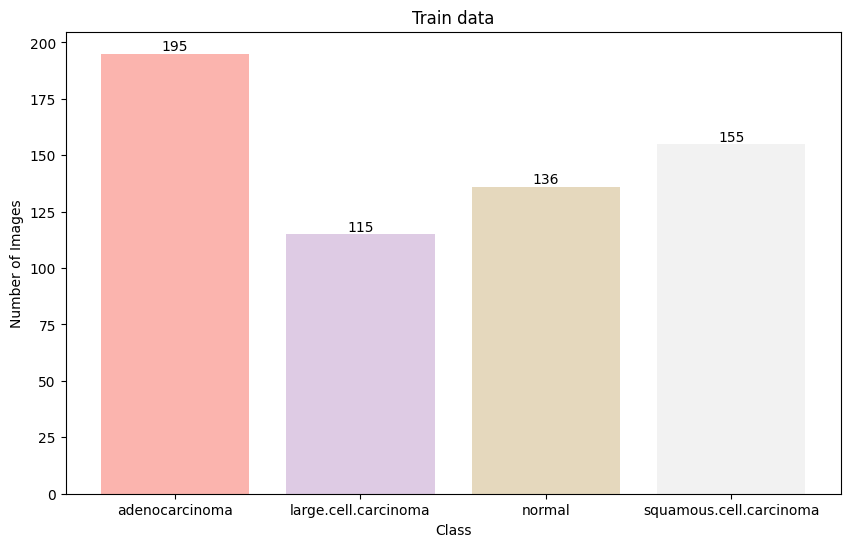

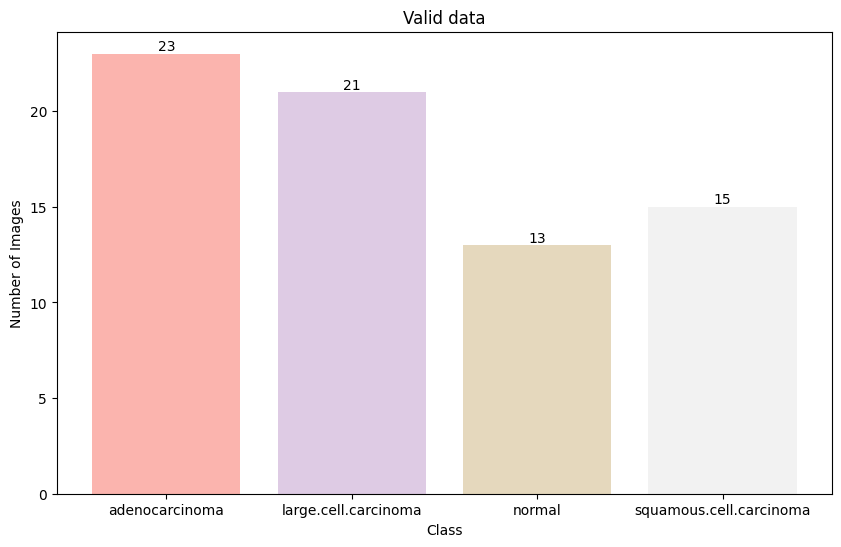

time: 1.72 s (started: 2024-04-16 11:03:44 +00:00)


In [25]:
def plot_nimages(dataset, count, name):
    class_names = list(dataset.labels.keys())
    counts = [count[dataset.labels[class_name]] for class_name in class_names]

    colors = plt.cm.Pastel1(np.linspace(0, 1, len(class_names)))

    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(class_names):
        plt.bar(class_name, counts[i], color=colors[i])

    plt.title(name)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')

    for index, value in enumerate(counts):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.show()

plot_nimages(train_dataset, train_count, name='Train data')
plot_nimages(valid_dataset, valid_count, name='Valid data')

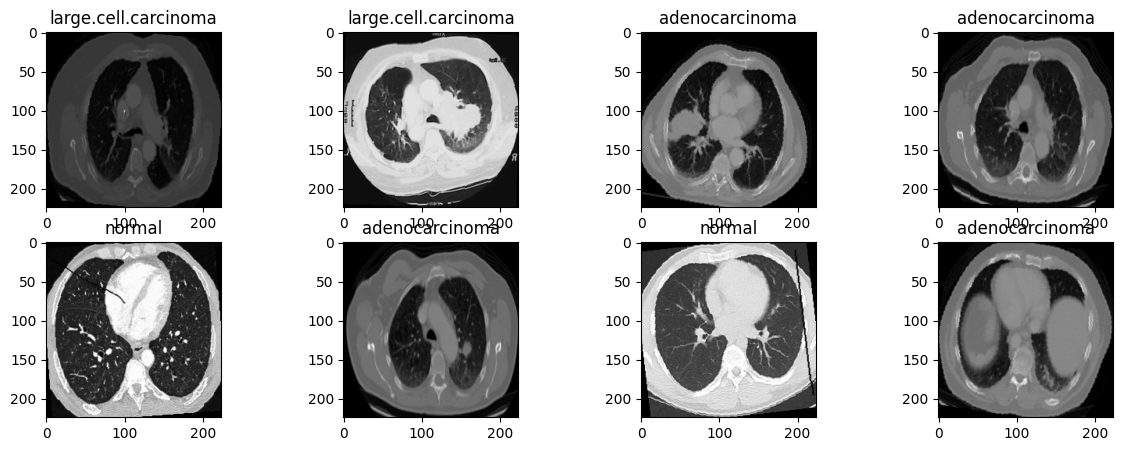

time: 2 s (started: 2024-04-16 11:03:57 +00:00)


In [26]:
train_dataset.show_images(num_images=8, rows=2)

## CNN Architecture explanation

The architecture of a Convolutional Neural Network (CNN) typically involves a series of convolutional layers, pooling layers, and fully connected layers. The specific numbers of each type of layer and their configurations can be chosen based on empirical evidence, computational resources, and the complexity of the task at hand. Here's the rationale for the architecture I provided:

    Convolutional Layers:
        These layers are the core building blocks of a CNN. They apply a number of filters (also known as kernels) to the input to create feature maps. These feature maps capture spatial hierarchies and features (e.g., edges, textures) from the input images. Increasing the number of convolutional layers allows the network to learn more complex patterns. As we go deeper into the network, the filters can capture higher-level features (e.g., shapes, specific parts of an object).

    Number of Filters:
        The number of filters in each convolutional layer often increases with the depth of the network. This is because the complexity and the number of high-level features tend to increase as you move deeper, and more filters are needed to capture this complexity. Common practice is to double the number of filters after each pooling layer, which helps to balance the reduction in spatial dimensions.

    Pooling Layers:
        Pooling layers (in this case, max pooling) are used to reduce the spatial size of the representation, which decreases the number of parameters and computation in the network. This also helps to make the detection of features somewhat invariant to scale and orientation changes. Pooling helps to control overfitting by providing an abstracted form of the representation.

    Fully Connected Layers(commonly refered as fully connected(fc) layers):
        After the convolutional and pooling layers, the high-level reasoning in the neural network is done via fully connected layers. Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. The last fully connected layer (which is often called the "output layer") has as many neurons as there are classes in the dataset for a classification task. Each neuron in this layer will correspond to a class score.

    Activation Functions:
        The ReLU activation function is used after each convolution operation to introduce non-linear properties to the system, allowing the network to learn more complex functions.

The architecture I described is a simple and somewhat generic model for illustrative purposes. In practice, the architecture might need adjustments. For instance, if the images are larger, you may have additional layers to further reduce the spatial dimensions before flattening for the fully connected layers. If there are more or fewer classes, or if the images are more or less complex, you would adjust the depth of the network and the number of neurons in the fully connected layers accordingly.

Additionally, state-of-the-art CNN architectures like ResNet, Inception, and DenseNet use a lot of other strategies like skip connections, depth-wise separable convolutions, and densely connected layers to improve performance. These designs are often the result of extensive experimentation and research to optimize network performance on large-scale image recognition tasks.

In [27]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.feature_size = 128 * 28 * 28

        # Linear layers
        self.fc1 = nn.Linear(self.feature_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, self.feature_size)  # Flatten the output

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

time: 948 µs (started: 2024-04-16 11:04:05 +00:00)


### Pooling layer inputs

    nn.MaxPool2d: Indicates that this is a 2-dimensional max pooling layer. Max pooling takes the maximum value over each patch of the feature map within the specified kernel size.

    kernel_size=2: Defines the size of the window over which the max operation is performed. In this case, it's a 2x2 window.

    stride=2: Determines the step size of the window as it slides over the feature map. A stride of 2 means that the window will move 2 pixels at a time, which reduces the size of the feature map by half.

### Why 2 linear layers

    self.fc1: This is the first fully connected layer. It takes the flattened output from the last pooling layer as input. In the given example, the input size is 128 * 28 * 28, which is the number of features from the last convolutional layer (128 feature maps) times the size of each feature map after pooling (28 x 28). The 512 is an arbitrary number of neurons in this layer and is a hyperparameter that you can tune. This layer's purpose is to take the numerous features and begin the process of combining them in various ways to identify more complex patterns that can be used for classification.

    self.fc2: This is the second and final fully connected layer in the model, which acts as the output layer. It takes as input the number of neurons in the previous fully connected layer (512 in this case) and outputs a vector of size num_classes, where num_classes represents the number of target classes for your classification task. The output of this layer is then typically passed through a softmax function (not shown in the forward method because it's often included in the loss function in PyTorch, nn.CrossEntropyLoss), which converts the logits to probabilities for each class.

    The exact size of the input to the first fully connected layer depends on the size of the output from the final pooling layer, so you would need to calculate this based on your network's specific architecture. If you change the size of the images or the architecture of the convolutional and pooling layers, you'll need to adjust the input dimension of self.fc1 accordingly.

### Why ReLU (Rectified Linear Unit)  instead of tanh (hyperbolic tangent)
ReLU is generally preferred due to its computational efficiency and because it helps alleviate the vanishing gradient problem, leading to faster convergence in many cases. However, the best choice can depend on the specific problem and the architecture of the network. It's common to try different activation functions and empirically determine which one works best for your specific task.

In [28]:
device = torch.device('cuda:0')

model = SimpleCNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


# Training function
def train_model(train_dataloader, model, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Validation function
def validate_model(valid_dataloader, model, device, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Collect predictions and true labels
            all_predictions.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_loss = running_loss / len(valid_dataloader)
    accuracy = correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}')

    # Concatenate all batches
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    return all_labels, all_predictions

# Run the training and validation
num_epochs = 100
train_model(train_dataloader, model, criterion, optimizer, num_epochs)
y_true, y_pred = validate_model(valid_dataloader, model, device, criterion)

Epoch 1/100, Loss: 20.2924
Epoch 2/100, Loss: 2.6183
Epoch 3/100, Loss: 1.4789
Epoch 4/100, Loss: 1.3956
Epoch 5/100, Loss: 1.3411
Epoch 6/100, Loss: 1.2904
Epoch 7/100, Loss: 1.2938
Epoch 8/100, Loss: 1.2465
Epoch 9/100, Loss: 1.2453
Epoch 10/100, Loss: 1.2042
Epoch 11/100, Loss: 1.2038
Epoch 12/100, Loss: 1.2990
Epoch 13/100, Loss: 1.3773
Epoch 14/100, Loss: 1.1492
Epoch 15/100, Loss: 1.2122
Epoch 16/100, Loss: 1.0433
Epoch 17/100, Loss: 0.9310
Epoch 18/100, Loss: 0.9301
Epoch 19/100, Loss: 0.8442
Epoch 20/100, Loss: 0.8194
Epoch 21/100, Loss: 0.7825
Epoch 22/100, Loss: 0.7387
Epoch 23/100, Loss: 0.7025
Epoch 24/100, Loss: 0.6719
Epoch 25/100, Loss: 0.6397
Epoch 26/100, Loss: 0.5807
Epoch 27/100, Loss: 0.5889
Epoch 28/100, Loss: 0.5130
Epoch 29/100, Loss: 0.5450
Epoch 30/100, Loss: 0.4814
Epoch 31/100, Loss: 0.4443
Epoch 32/100, Loss: 0.5040
Epoch 33/100, Loss: 0.3334
Epoch 34/100, Loss: 0.4327
Epoch 35/100, Loss: 0.3192
Epoch 36/100, Loss: 0.2635
Epoch 37/100, Loss: 0.2610
Epoch 38/

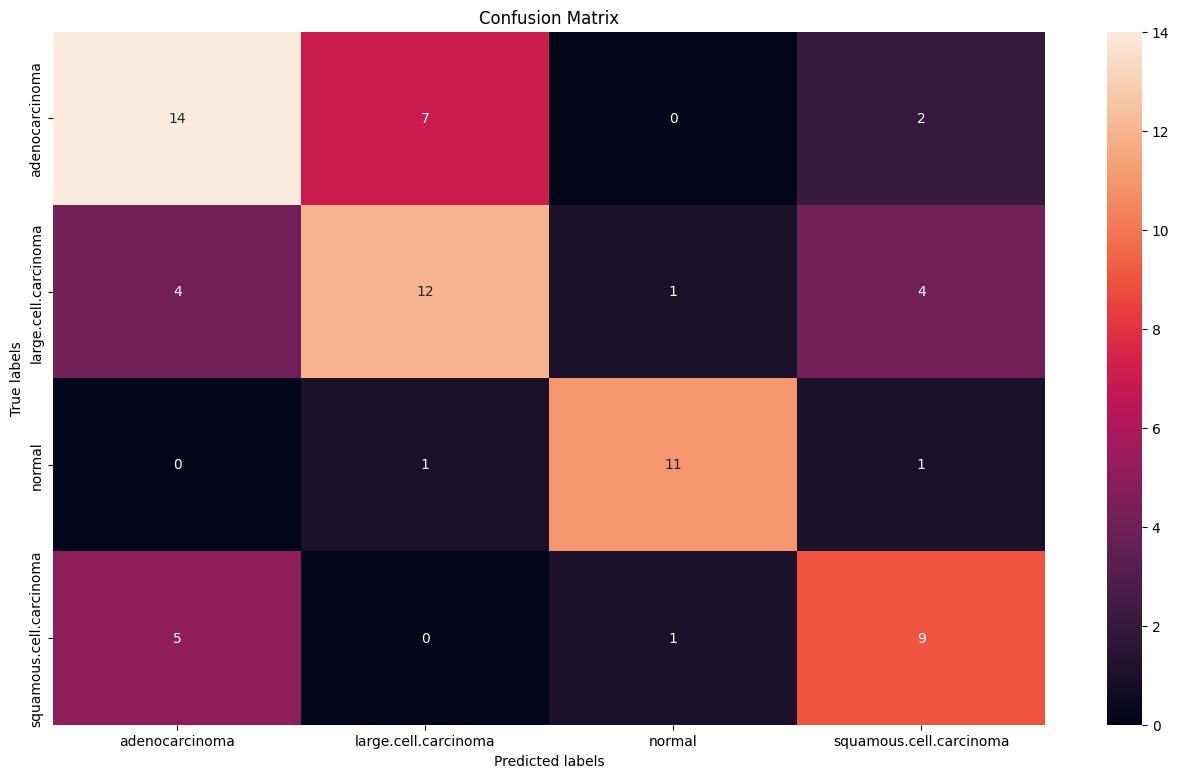

time: 320 ms (started: 2024-04-16 11:24:54 +00:00)


In [29]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(16,9))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  # 'g' formatter ensures numerical display

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'])
ax.yaxis.set_ticklabels(['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'])
plt.show()